In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
!pip install scapy

  Stored in directory: C:\Users\Acer\AppData\Local\pip\Cache\wheels\2c\e7\01\f097df99ac9cd0d4f744c255f918d471d7a4b0766bc84c38c3
Successfully built scapy


In [174]:
train_df = pd.read_csv("server-retry-vn.csv", index_col=0)
print(train_df.size)
train_df.head()

11312


,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
Run,,,,,,,,
0,quic-go,server,quic_server_test_version_negociation0,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
1,NaN,server,quic_server_test_retry0,NaN,server_return_code(1)+timeout,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
2,NaN,server,quic_server_test_retry0,NaN,server_return_code(1)+timeout,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
3,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
4,mvfst,server,quic_server_test_retry0,NaN,frame.connection_close:{err_code:0x16d}+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0


In [175]:
server_name = train_df.Implementation.unique()
print(server_name)
servers = []
for s in server_name:
    if s  is np.nan:
        pass
    elif "cargo run --manifest-path=tools/apps/Cargo.toml" in s:
        servers.append("quiche")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quiche")
    elif "cargo run" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    elif "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    elif "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    elif "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    elif "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    elif "python3" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    elif "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")
        
print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)
train_df = train_df[train_df["Implementation"].notna()]
train_df = train_df[train_df["Implementation"] != "aioquic"]
train_df = train_df[train_df["Implementation"] != "mvfst"]
print(train_df.size)
train_df.head()

['quic-go' nan 'quiche' 'mvfst' 'quinn' 'picoquic' 'quant']
[]
8080


,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
Run,,,,,,,,
0,quic-go,server,quic_server_test_version_negociation0,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
3,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
5,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
8,quinn,server,quic_server_test_retry0,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
9,picoquic,server,quic_server_test_retry0,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0


In [176]:

for i, row in train_df.iterrows():
    resultFile = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/"):]
    f = open(resultFile, "r")
    content = f.read()
    #if not "recv_retry_pkt" in content and "quic_server_test_retry0" in resultFile: 
         #print(resultFile)
    #     train_df.drop(axis=0,inplace=True,labels=[i]) 
    #elif not "recv_vn_pkt" in content and "quic_server_test_version_negociation0" in resultFile: 
         #print(resultFile)
    #     train_df.drop(axis=0,inplace=True,labels=[i])
    if row["isPass"] == 0.0:
        if "frame.connection_close:" in content and not "err_code:0" in content:
            start_index = content.find("frame.connection_close:")
            end_index = content.find("}",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1]
        elif "frame.connection_close:{err_code:0" in train_df.loc[i, "ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "No Error"
            row["isPass"] = 1.0
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content:
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault"
        elif "ivy_return_code(139)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 139"
        elif 'timeout+> client' in content:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed" 
        elif 'timeout+> client' in content:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed" 
        elif 'timeout+< undecryptable_packet_event' in train_df.loc[i, "ErrorIEV"]  \
            or "timeout+< cipher_packet(" in train_df.loc[i, "ErrorIEV"] \
            or "timeout+> tls_recv_event(" in train_df.loc[i, "ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed (undecryptable_packet_event)" 
        elif 'timeout+> packet_event_vn(' in train_df.loc[i, "ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed (unable to proceed VN)" 
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"

        
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")
        
print(train_df.size)
train_df.head()

8080


,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
Run,,,,,,,,
0,quic-go,server,quic_server_test_version_negociation0,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
3,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
5,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
8,quinn,server,quic_server_test_retry0,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
9,picoquic,server,quic_server_test_retry0,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0


In [177]:
train_df.TestName.unique()

array(['quic_server_test_version_negociation0', 'quic_server_test_retry0'],
      dtype=object)

In [178]:
train_df["ErrorIEV"].unique().tolist()

['No Error',
 'require conn_total_data(the_cid) > 0+',
 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+',
 'require  bytes_to_itoken(expected_itoken) = pkt.integrity_token+',
 'Handshake not completed (undecryptable_packet_event)',
 'timeout+< show_set_initial_keys([00000000x2])']

In [179]:
from scapy.all import *

for index, row in train_df.iterrows():
    outfile = row["OutputFile"]
    if "iev" in row["OutputFile"] :
        i = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/server-retry-vn/"):]
        i = i.split("/")[0]
        #print(i)
        if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
            resultFile = "server-retry-vn/" + str(i) + "_" + row["Implementation"] + "_" + str(row["TestName"][:-1]) + ".pcap"
            #print(resultFile)
            if os.path.isfile(resultFile):
                try:
                    packets = rdpcap(resultFile)
                    ln = len(packets)
                    train_df.loc[index, "NbPktSend"] = ln
                except:
                    pass

train_df.head()

,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
Run,,,,,,,,
0,quic-go,server,quic_server_test_version_negociation0,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,71.0,1.0
3,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,29.0,0.0
5,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,32.0,0.0
8,quinn,server,quic_server_test_retry0,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,19.0,0.0
9,picoquic,server,quic_server_test_retry0,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,21.0,1.0


In [180]:
train_df["ErrorOUT"] = ""
train_df["ErrorERR"] = ""
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/"):]
        resultFile = resultFile.replace(".iev",".out")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorOUT"] = content[start_index:end_index+1]
        resultFile = resultFile.replace(".iev",".err")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorERR"] = content[start_index:end_index+1]
                        
train_df.head()

,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass,ErrorOUT,ErrorERR
Run,,,,,,,,,,
0,quic-go,server,quic_server_test_version_negociation0,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,71.0,1.0,,
3,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,29.0,0.0,,
5,quiche,server,quic_server_test_retry0,NaN,require conn_total_data(the_cid) > 0+,/home/user/Documents/QUIC-FormalVerification/r...,32.0,0.0,,
8,quinn,server,quic_server_test_retry0,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,19.0,0.0,\n,\n
9,picoquic,server,quic_server_test_retry0,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,21.0,1.0,,


In [181]:
train_df.to_csv(path_or_buf="server-retry-vn_processed.csv",index=False)

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

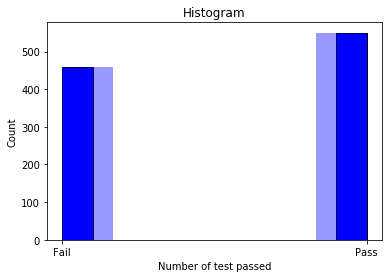

In [182]:
# matplotlib histogram

x = ["Pass","Fail"]

cnt = train_df['isPass'].value_counts()

plt.hist(train_df['isPass'], color = ['blue'], edgecolor = 'black')

# seaborn histogram
sns.distplot(train_df['isPass'], hist=True, kde=False, 
             color = ['blue'])

plt.xticks(np.arange(0, 2, 1))
positions = (0, 1)
labels = ("Fail", "Pass")
plt.xticks(positions, labels)
# Add labels
plt.title('Histogram')
plt.xlabel('Number of test passed')
plt.ylabel('Count')

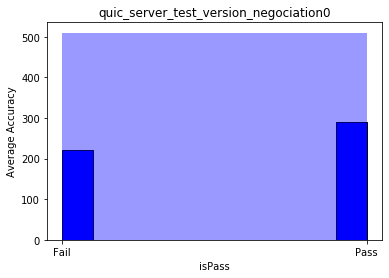

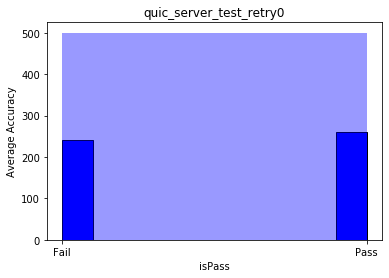

In [183]:
# Failure per test


tests = train_df.TestName.unique()


#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()
    

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


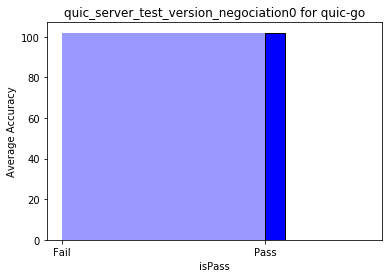

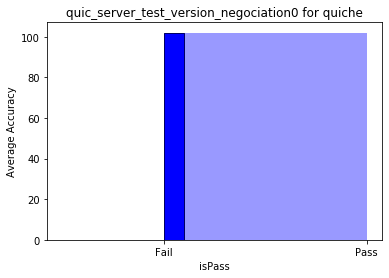

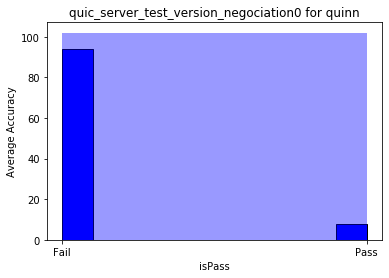

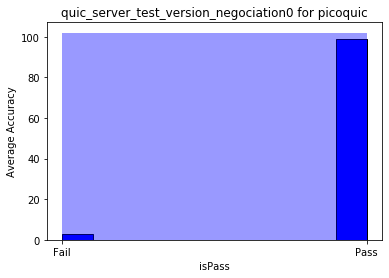

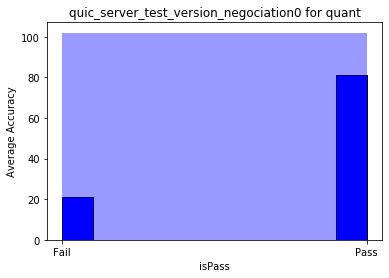

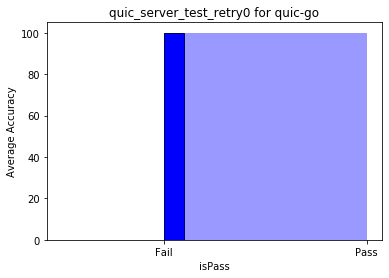

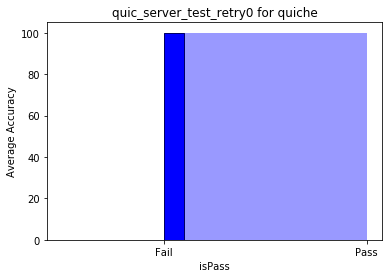

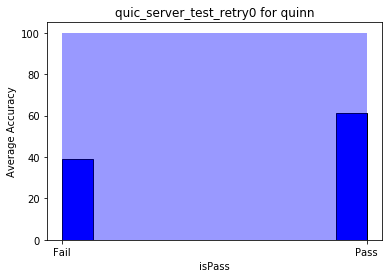

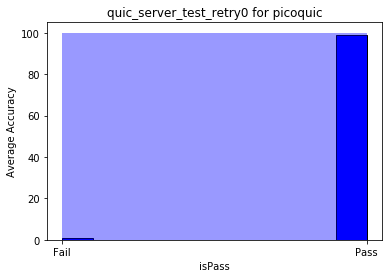

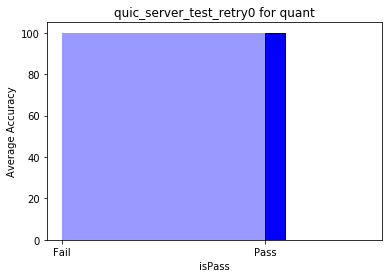

In [191]:
# Failure per test and per implementation


tests = train_df.TestName.unique()

servers = train_df.Implementation.unique() # ['quinn', 'lsquic', 'mvfst', 'picoquic', 'quant', 'quic-go', 'aioquic']
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.distplot(subsubdf['isPass'], hist=True, kde=False, 
                     color = 'blue',bins=[0, 1])
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('Average Accuracy')
        plt.show()
    

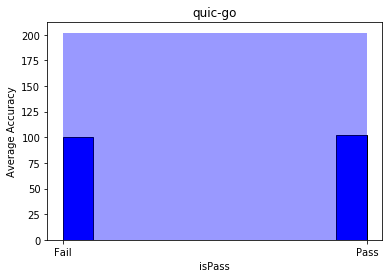

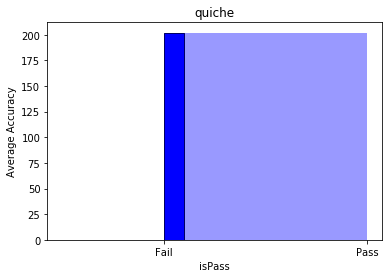

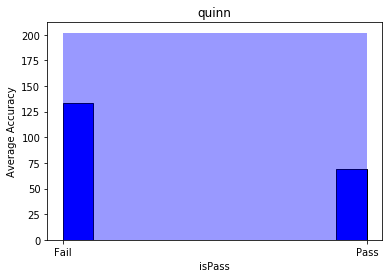

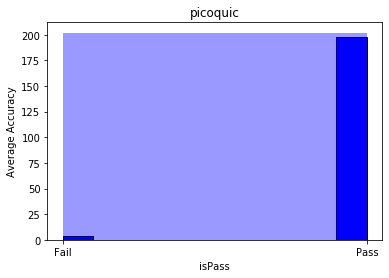

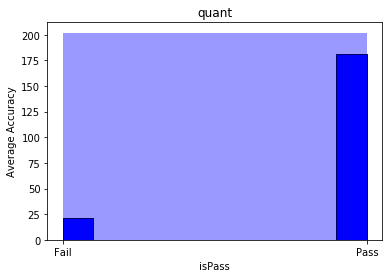

In [193]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()
    

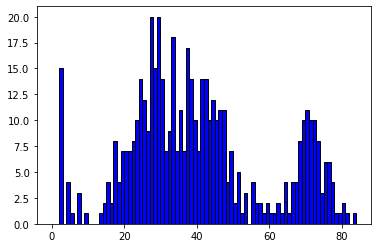

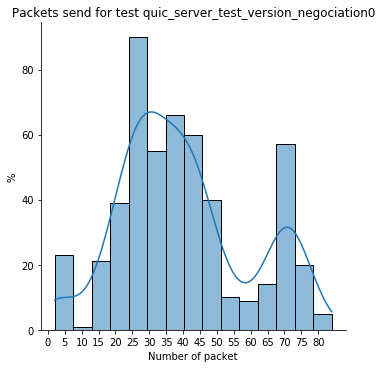

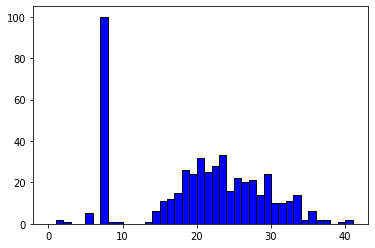

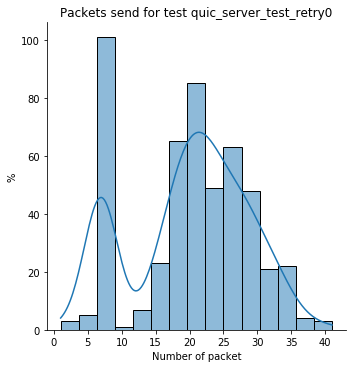

In [194]:
tests = train_df.TestName.unique()
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    #subdf = subdf.loc[subdf['Implementation'] != "quinn"]
    max_value = subdf["NbPktSend"].max() 
    
    plt.hist(subdf['NbPktSend'], color = 'blue', edgecolor = 'black',
             range = [0,max_value],bins=max(int(max_value),1))

    # seaborn histogram
    sns.displot(subdf['NbPktSend'],
                 kde=True)
    # Add labels
    plt.xticks(np.arange(0, int(max_value),5))
    # positions = (0, 1)
    # labels = ("Fail", "Pass")
    # plt.xticks(positions, labels)
    plt.title("Packets send for test " + t)
    plt.xlabel('Number of packet')
    plt.ylabel('%')
    filename = 'plot/' + "packets_" + t + '.png'
    #plt.savefig(filename)
    plt.show()

In [195]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    
    print(t)
    print(len(subdf.index))
    print(subdf["isPass"].sum())
    print()

quic-go
202
102.0

quiche
202
0.0

quinn
202
69.0

picoquic
202
198.0

quant
202
181.0



In [196]:
for t in tests: #servers:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers: # tests:
        ssubdf = subdf.loc[subdf['Implementation'] == s]
        print(t)
        print(s)
        print(len(ssubdf.index))
        print(ssubdf["isPass"].sum())
        print()

quic_server_test_version_negociation0
quic-go
102
102.0

quic_server_test_version_negociation0
quiche
102
0.0

quic_server_test_version_negociation0
quinn
102
8.0

quic_server_test_version_negociation0
picoquic
102
99.0

quic_server_test_version_negociation0
quant
102
81.0

quic_server_test_retry0
quic-go
100
0.0

quic_server_test_retry0
quiche
100
0.0

quic_server_test_retry0
quinn
100
61.0

quic_server_test_retry0
picoquic
100
99.0

quic_server_test_retry0
quant
100
100.0



quic_server_test_version_negociation0
quic-go
['No Error']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


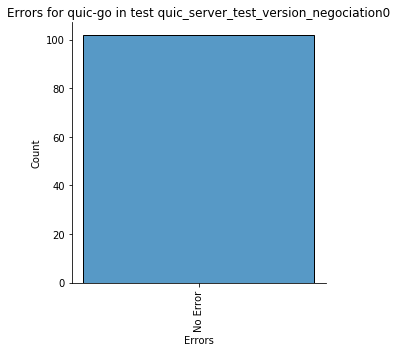

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_retry0
quic-go
['require conn_total_data(the_cid) > 0+', 'Handshake not completed (undecryptable_packet_event)']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_version_negociation0
quiche
['require conn_total_data(the_cid) > 0+', 'No Error', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+']


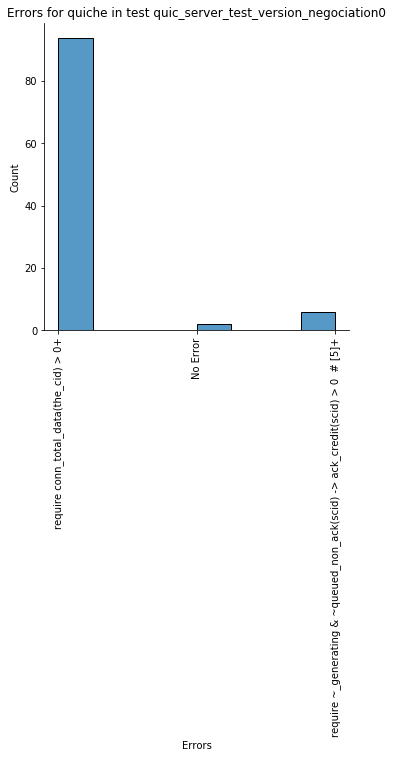

quic_server_test_retry0
quiche
['require conn_total_data(the_cid) > 0+', 'timeout+< show_set_initial_keys([00000000x2])']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


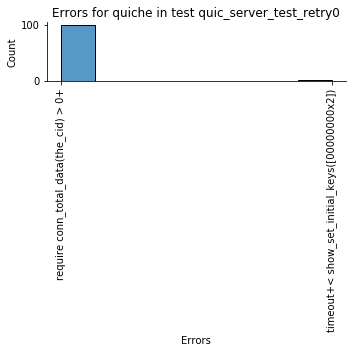

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_version_negociation0
quinn
['require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+', 'No Error', 'require  bytes_to_itoken(expected_itoken) = pkt.integrity_token+']


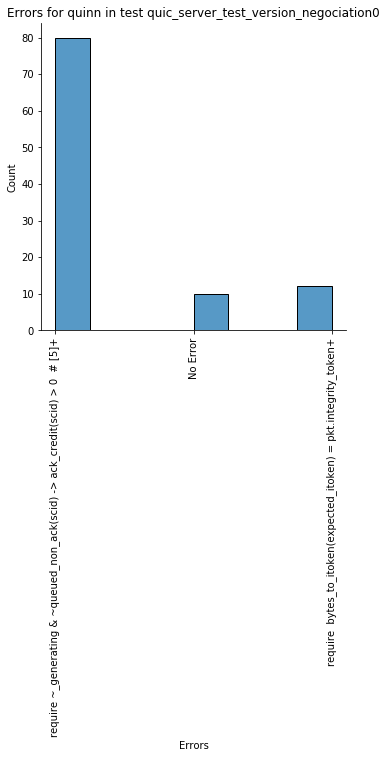

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_retry0
quinn
['require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+', 'No Error', 'require  bytes_to_itoken(expected_itoken) = pkt.integrity_token+', 'timeout+< show_set_initial_keys([00000000x2])']


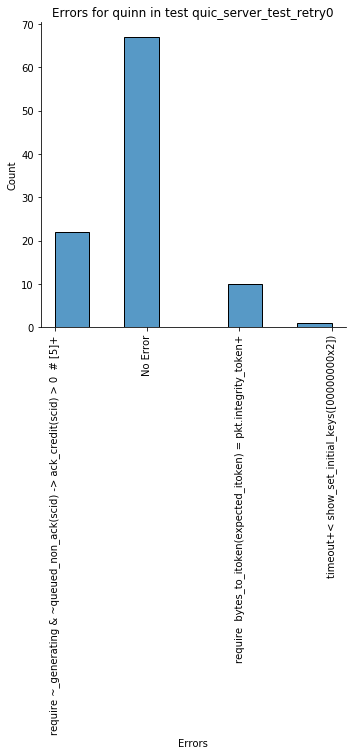

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_version_negociation0
picoquic
['No Error', 'require  bytes_to_itoken(expected_itoken) = pkt.integrity_token+']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_retry0
picoquic
['No Error', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+']


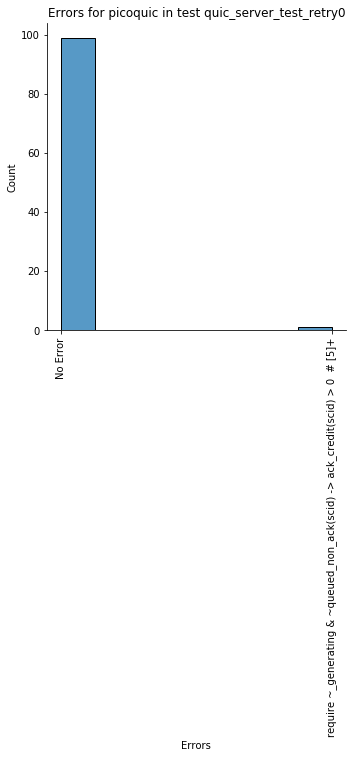

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_version_negociation0
quant
['require  bytes_to_itoken(expected_itoken) = pkt.integrity_token+', 'No Error']


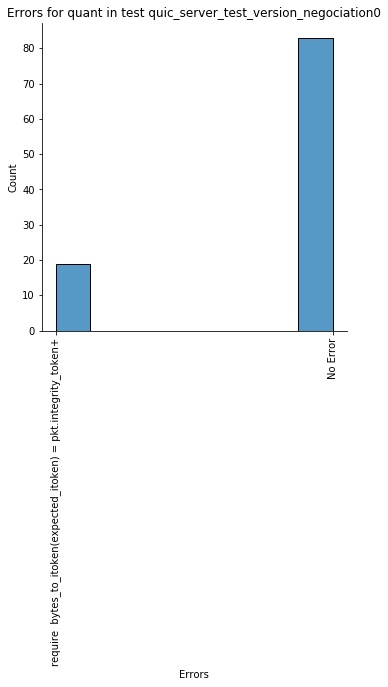

quic_server_test_retry0
quant
['No Error']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


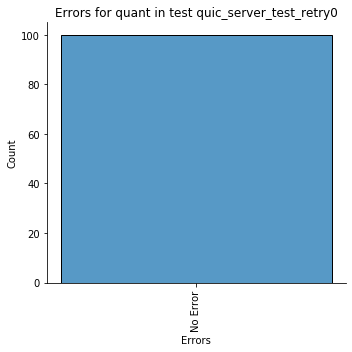

In [198]:
all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for s in servers:
    subdf = train_df.loc[train_df['Implementation'] == s]
    for t in tests:
        subsubdf = subdf.loc[subdf['TestName'] == t]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors.index(row["ErrorIEV"])
            res.append(ind)
        subsubdf["ErrorsCode"] = res
        
        print(t)
        print(s)
        print(all_errors)
        
                
        # seaborn histogram
        sns.displot(x=subsubdf['ErrorsCode'],  kde=False ) #,hue="Implementation"
        # Add labels
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)), rotation=90)  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(errors.tolist())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')
        filename = 'plot/' + "errors_for_" + s + "_in_test_" + t + '.png'
        fig = plt.gcf()
        plt.tight_layout()
        #fig.set_size_inches(20,20)
        #plt.savefig(filename, dpi=fig.dpi*2)
        plt.show()

In [197]:
all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for s in train_df["Implementation"].unique().tolist():
    subdf = train_df.loc[train_df['Implementation'] == s]
    for t in tests:
        subsubdf = subdf.loc[subdf['TestName'] == t]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        all_errors_ind = {all_errors[x]:x for x in range(len(all_errors))}

        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors_ind[row["ErrorIEV"]]
            res.append(ind)
        print(res)
        subsubdf["ErrorsCode"] = res
        
        print(t)
        print(s)
        print(all_errors)
        
        all_errors = subsubdf["ErrorsCode"].unique().tolist()        
        # seaborn histogramabs
        cnt = list()
        for error in all_errors:
            cnt = len(subsubdf.loc[subsubdf['ErrorsCode'] == error])
            print(cnt)
            sns.displot(x=cnt,kde=False)
            cnt = list()
        
        #sns.displot(x=subsubdf['ErrorsCode'],kde=False ) #,hue="Implementation"
        #for i in range(0,len(subsubdf['ErrorsCode'].uniques().tolist())):
            
        # Add labels
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)))  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(all_errors_ind.values())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')

        #plt.legend(handles=subsubdf['ErrorsCode'], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
        filename = 'plot/' + "errors_for_" + s + "_in_test_" + t + '.png'
        fig = plt.gcf()
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        fig.legend(labels=all_errors)
        plt.tight_layout()
        fig.set_size_inches(5,5)
        #plt.savefig(filename, dpi=fig.dpi*2)
        plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_version_negociation0
quic-go
['No Error']
102


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: If using all scalar values, you must pass an index

In [201]:
subdf = train_df.loc[train_df['TestName'] == 'quic_server_test_version_negociation0']
subsubdf = subdf.loc[subdf['Implementation'] == 'quiche']
print(subsubdf.loc[subsubdf["ErrorIEV"] == 'No Error']["OutputFile"])
#print(subsubdf.loc[subsubdf['TestName'] == 'quic_server_test_stream']["OutputFile"][67][-50:])

Run
45     /home/user/Documents/QUIC-FormalVerification/r...
660    /home/user/Documents/QUIC-FormalVerification/r...
Name: OutputFile, dtype: object


In [203]:
subdf = train_df.loc[train_df['TestName'] == 'quic_server_test_version_negociation0']
subsubdf = subdf.loc[subdf['Implementation'] == 'quiche']
print(subsubdf.loc[subsubdf["ErrorIEV"] == 'No Error']["OutputFile"][45][-50:])
#print(subsubdf.loc[subsubdf['TestName'] == 'quic_server_test_stream']["OutputFile"][67][-50:])

ry-vn/27/quic_server_test_version_negociation0.iev
